In [104]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import colorcet as cc
from dynamical_systems.continuous import solve_ode, Lorenz63
from dynamical_systems.dataset import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.models import NeuralODE
from dynamics_discovery.preprocessing import split_into_chunks, standardize, add_noise
from matplotlib_utils.axes_setters import set_labels

plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

In [ ]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz63.hdf5")[30000:]
# dataset_loaded = TimeSeriesDataset.load("./data/lorenz_larger_tol.hdf5")
t_train = dataset_loaded.t
u_train = standardize(dataset_loaded.u[0])


In [3]:
dataset_loaded

TimeSeriesDataset(
  t=f64[1,100000],
  u=f64[1,100000,3],
  u0=f64[1,3],
  metadata={
    'atol': 1e-09,
    'dynamics': 'Lorenz63(sigma=10, beta=2.6666666666666665, rho=28)',
    'rtol': 1e-09,
    'solver': 'Tsit5()'
  }
)

In [ ]:
key = 0
train_length = 100
noise = 0.05
model_type = "neuralode"
model = load_model(
    f"results/lorenz63/{model_type}/len={train_length}_noise={noise}_key={key}.eqx"
)
t_train_batch = split_into_chunks(dataset_loaded.t[0], train_length)
u_train_batch = split_into_chunks(u_train, train_length)
u_train_batch = add_noise(u_train_batch, noise, key=0)

subsample_factor = u_train_batch.shape[0] // 100
print(t_train_batch.shape)
u_pred_train = eqx.filter_vmap(model.solve)(
    t_train_batch[::subsample_factor], u_train_batch[::subsample_factor, 0]
)
u_pred_test = model.solve(dataset_loaded.t[0], u_train[0], max_steps=None)


(1000, 100)


In [ ]:
u_train_batch.shape

(1000, 100, 3)

In [ ]:
u_train_noise = jnp.reshape(u_train_batch, (-1, 3))
u_train, u_train_noise, u_pred_train, u_pred_test = jax.tree.map(
    np.asarray, (u_train, u_train_noise, u_pred_train, u_pred_test)
)

Text(0.5, 0.98, 'NeuralODE prediction (train length = 100, seed = 0)')

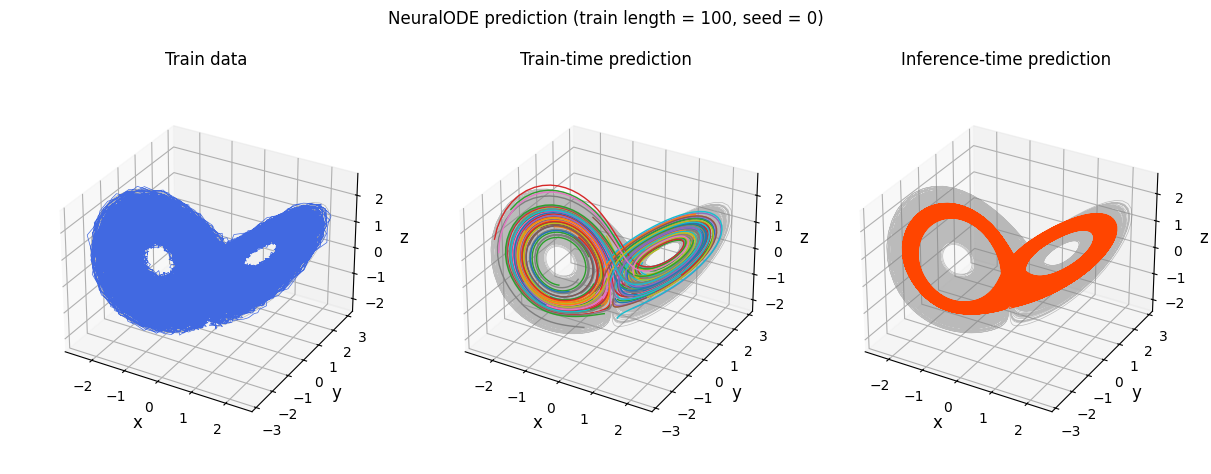

In [ ]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(12, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].set_title("Train data")
axes[0].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
axes[0].plot(*u_train_noise.T, color="royalblue", **plot_kwargs)

axes[1].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
for u_i in np.asarray(u_pred_train)[::]:
    axes[1].plot(*u_i.T, linewidth=1.0)
axes[1].set_title("Train-time prediction")
axes[2].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
axes[2].plot(*u_pred_test.T, color="orangered", **plot_kwargs)
axes[2].set_title("Inference-time prediction")

for ax in axes:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)
    ax.set_title
fig.suptitle(f"NeuralODE prediction (train length = {train_length}, seed = {key})")
# fig.suptitle(r"32 bit precision, noise = 0")
# fig.suptitle(r"64 bit precision, noise ~ $\mathscr{N}(0, 0.05\cdot\sigma_{data})$")

Text(0.5, 0.98, 'Comparison of distributions for train_length=77')

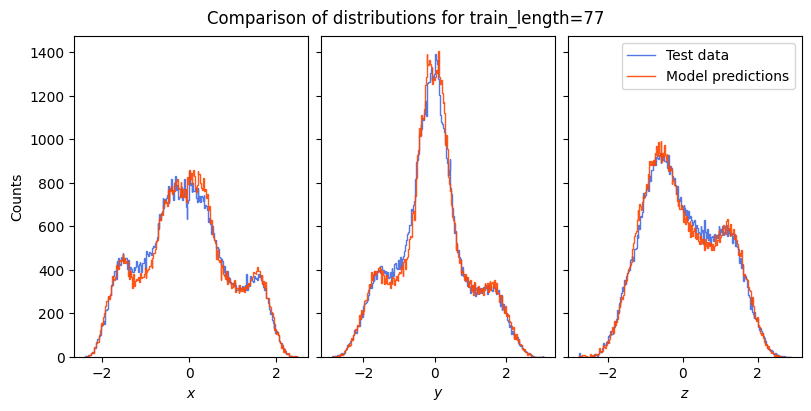

In [7]:
u_test_minmax = jnp.min(u_test, axis=0), jnp.max(u_test, axis=0)
u_pred_test_minmax = jnp.min(u_pred_test, axis=0), jnp.max(u_pred_test, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True, sharey=True)
xlabels = ("x", "y", "z")
for i, (ax, xlb) in enumerate(zip(axes, xlabels)):
    bins = np.linspace(
        min(u_test_minmax[0][i], u_pred_test_minmax[0][i]),
        max(u_test_minmax[1][i], u_pred_test_minmax[1][i]),
        250,
    )
    ax.stairs(
        *np.histogram(u_test[:, i], bins),
        color="royalblue",
        alpha=0.9,
        label="Test data",
    )
    ax.stairs(
        *np.histogram(u_pred_test[:, i], bins),
        color="orangered",
        alpha=0.9,
        label="Model predictions",
    )
    ax.set_xlabel(f"${xlb}$")
    # ax.set_yscale("log", base=10)
axes[0].set_ylabel("Counts")
axes[-1].legend(loc="upper right")
fig.suptitle(f"Comparison of distributions for {train_length=}")

In [35]:
def filter_map(fun, tree):
    params, static = eqx.partition(tree, eqx.is_array)
    params_mapped = jax.tree.map(fun, params)
    return eqx.combine(params_mapped, static)

In [9]:
neuralode, t, u_test = filter_map(
    jnp.float32, (NeuralODE(3, 32, 3), dataset_loaded.t, u_test)
)


In [36]:
from jaxtyping import Array, Float
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d


def normalized_fft_intensity(x: Float[Array, "time dim"]):
    x_fft = jnp.fft.rfft(x, axis=0, norm="ortho")
    intensity = jnp.abs(x_fft) ** 2
    return intensity / jnp.sum(intensity, axis=0)


@jax.jit
def hellinger_dim(u_true, u_pred):
    intensity_true = normalized_fft_intensity(u_true)
    intensity_pred = normalized_fft_intensity(u_pred)
    integral_pq = jnp.trapezoid(jnp.sqrt(intensity_true * intensity_pred), axis=0)
    return jnp.mean(1 - integral_pq)


def compute_and_smooth_power_spectrum(x, smoothing):
    x_ = (x - x.mean()) / x.std()
    fft_real = np.fft.rfft(x_)
    ps = np.abs(fft_real) ** 2 * 2 / len(x_)
    ps_smoothed = gaussian_filter1d(ps, smoothing)
    return ps_smoothed / ps_smoothed.sum()


def hellinger_distance(p, q):
    return np.sqrt(1 - np.sum(np.sqrt(p * q)))


def power_spectrum_error(X, X_gen, smoothing):
    dists = []
    for i in range(X.shape[1]):
        ps = compute_and_smooth_power_spectrum(X[:, i], smoothing)
        ps_gen = compute_and_smooth_power_spectrum(X_gen[:, i], smoothing)
        dists.append(hellinger_distance(ps, ps_gen))
    return np.mean(dists)


def calc_histogram(x, n_bins, min_, max_):
    dim_x = x.shape[1]  # number of dimensions

    coordinates = jnp.astype((n_bins * (x - min_) / (max_ - min_)), dtype=jnp.int64)

    # discard outliers
    coord_bigger_zero = coordinates > 0
    coord_smaller_nbins = coordinates < n_bins
    inlier = coord_bigger_zero.all(1) * coord_smaller_nbins.all(1)
    coordinates = coordinates[inlier]

    size_ = tuple(n_bins for _ in range(dim_x))
    indices = jnp.ones(coordinates.shape[0], device=coordinates)
    if "cuda" == coordinates.device.type:
        tens = torch.cuda.sparse.FloatTensor
    else:
        tens = torch.sparse.FloatTensor
    return tens(coordinates.t(), indices, size=size_).to_dense()


def normalize_to_pdf_with_laplace_smoothing(histogram, n_bins, smoothing_alpha=10e-6):
    if histogram.sum() == 0:  # if no entries in the range
        pdf = None
    else:
        dim_x = len(histogram.shape)
        pdf = (histogram + smoothing_alpha) / (
            histogram.sum() + smoothing_alpha * n_bins**dim_x
        )
    return pdf


def kullback_leibler_divergence(p1, p2):
    """
    Calculate the Kullback-Leibler divergence
    """
    if p1 is None or p2 is None:
        kl = jnp.asarray(float("nan"))
    else:
        kl = jnp.sum((p1 * jnp.log(p1 / p2)))
    return kl


def state_space_divergence_binning(x_gen, x_true, n_bins=30):
    x_true_ = jnp.asarray(x_true)
    x_gen_ = jnp.asarray(x_gen)
    min_, max_ = x_true_.min(0), x_true_.max(0)
    hist_gen = calc_histogram(x_gen_, n_bins=n_bins, min_=min_, max_=max_)
    hist_true = calc_histogram(x_true_, n_bins=n_bins, min_=min_, max_=max_)

    p_gen = normalize_to_pdf_with_laplace_smoothing(histogram=hist_gen, n_bins=n_bins)
    p_true = normalize_to_pdf_with_laplace_smoothing(histogram=hist_true, n_bins=n_bins)
    return kullback_leibler_divergence(p_true, p_gen)


def clean_from_outliers(prior, posterior):
    nonzeros = prior != 0
    if any(prior == 0):
        prior = prior[nonzeros]
        posterior = posterior[nonzeros]
    outlier_ratio = jnp.mean(1 - jnp.astype(nonzeros, jnp.float_))
    return prior, posterior, outlier_ratio


def eval_likelihood_gmm_for_diagonal_cov(z, mu, std):
    T = mu.shape[0]
    mu = jnp.reshape((1, T, -1))(mu)

    vec = z - mu  # calculate difference for every time step
    vec = vec
    precision = 1 / (std**2)
    precision = jnp.diag(precision)

    prec_vec = jnp.einsum("zij,azj->azi", precision, vec)
    exponent = jnp.einsum("abc,abc->ab", vec, prec_vec)
    sqrt_det_of_cov = jnp.prod(std, dim=1)
    likelihood = jnp.exp(-0.5 * exponent) / sqrt_det_of_cov
    return likelihood.sum(dim=1) / T


def state_space_divergence_gmm(X_gen, X_true, scaling=1.0, max_used=10000):
    time_steps = min(X_true.shape[0], max_used)
    mu_true = X_true[:time_steps, :]
    mu_gen = X_gen[:time_steps, :]

    cov_true = jnp.ones(X_true.shape[-1]).repeat(time_steps, 1) * scaling
    cov_gen = jnp.ones(X_gen.shape[-1]).repeat(time_steps, 1) * scaling

    mc_n = 1000
    key1, key2 = jax.random.split(0, 2)
    t = jax.random.randint(
        key1,
        (mc_n,),
        0,
        mu_true.shape[0],
    )

    std_true = jnp.sqrt(cov_true)
    std_gen = jnp.sqrt(cov_gen)

    z_sample = (
        mu_true[t] + std_true[t] * jax.random.normal(key2, mu_true[t].shape)
    ).reshape((mc_n, 1, -1))

    prior = eval_likelihood_gmm_for_diagonal_cov(z_sample, mu_gen, std_gen)
    posterior = eval_likelihood_gmm_for_diagonal_cov(z_sample, mu_true, std_true)
    prior, posterior, outlier_ratio = clean_from_outliers(prior, posterior)
    kl_mc = jnp.mean(jnp.log(posterior + 1e-8) - jnp.log(prior + 1e-8), dim=0)
    return kl_mc

In [37]:
u_preds = []
hellingers = []
kl = []
batch_lengths = jnp.asarray([2, 5, 10, 20, 50, 77, 100, 125])
for seed in (0, 10, 20):
    u_pred_i = []
    hellinger_i = []
    kl_i = []
    for length in tqdm(batch_lengths):
        model = load_model(
            f"results/lorenz63/{model_type}/len={length}_noise={noise}_key={seed}.eqx"
        )
        u_pred = model.solve(dataset_loaded.t, u_train[0], max_steps=None)
        u_pred_i.append(u_pred)
        hellinger_i.append(power_spectrum_error(u_train, u_pred, 20))
        # kl_i.append(state_space_divergence_binning(u_train, u_pred, 30))
    u_preds.append(jnp.asarray(u_pred_i))
    hellingers.append(jnp.asarray(hellinger_i))
    kl.append(jnp.asarray(kl_i))

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:16<00:00,  9.52s/it]


In [38]:
u_preds = jnp.asarray(u_preds)
u_preds.shape

(3, 8, 100000, 3)

In [18]:
models = [
    eqx.tree_deserialise_leaves(
        f"./results/lorenz_length={length}_key=0.eqx", neuralode
    )
    for length in batch_lengths
]
model_stacked = jax.tree.map(lambda *args: jnp.stack(args, axis=0), *models)

NameError: name 'neuralode' is not defined

In [39]:
hellinger = jnp.asarray(hellingers)
# hellinger = jax.vmap(jax.vmap(hellinger_dim, in_axes=(None, 0)), in_axes=(None, 0))(
#     u_train, u_preds
# )

In [40]:
hellinger.shape

(3, 8)

Text(0.5, 1.0, 'Neural ODE on Lorenz63 (noise=0.05)')

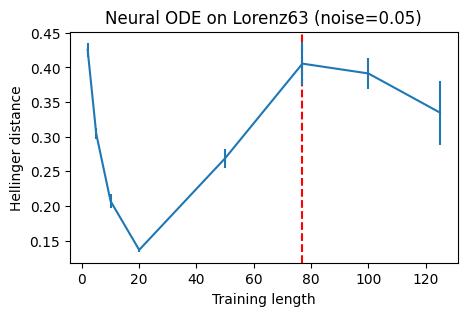

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.axvline(x=77, linestyle="--", color="red")
ax.errorbar(
    batch_lengths,
    jnp.mean(hellinger, axis=0),
    yerr=jnp.std(hellinger, axis=0),
)
ax.set_xlabel("Training length")
ax.set_ylabel("Hellinger distance")
ax.set_title(f"Neural ODE on Lorenz63 (noise={noise})")


In [29]:
hellinger

Array([[0.07145356, 0.05046396, 0.03722693, 0.05243522, 0.06896698,
        0.0827081 , 0.14833891, 0.2425569 ],
       [0.06403831, 0.0420689 , 0.04763602, 0.04708084, 0.32475918,
        0.04732662, 0.09038995, 0.24757708],
       [0.06500414, 0.05615036, 0.04496724, 0.06075387, 0.06659488,
        0.06436511, 0.10407926, 0.2658746 ]], dtype=float64)

## Evaluate Jacobian error of the trained models over the attractor

In [21]:
t_train = dataset_loaded.t[0]
u_train = standardize(dataset_loaded.u[0])
sigmas = jnp.std(dataset_loaded.u[0], axis=0)

lorenz = Lorenz63()
jac_true = eqx.filter_vmap(lorenz.jacobian, in_axes=(None, 0))(
    dataset_loaded.t[0], dataset_loaded.u[0]
)
# jac_true = jnp.diag(1 / sigmas) @ jac_true_unscaled

In [16]:
jac_true.shape

(100000, 3, 3)

In [60]:
model1 = load_model("results/lorenz63/neuralode/len=77_noise=0.05_key=0.eqx")
model2 = load_model("results/lorenz63/neuralode/len=100_noise=0.05_key=0.eqx")


def model_jacobian(model, ts, us):
    @eqx.filter_jacfwd
    def _jacobian(t_u):
        t, u = t_u
        return model.rhs(t, u, None)

    @eqx.filter_vmap
    def jacobian(t, u):
        return _jacobian((t, u))

    return jacobian(ts, us)


def calculate_relative_jacerr(model, ts, us, jac_true):
    jac_model = model_jacobian(model, ts, us)[1]
    jacerr = jnp.linalg.norm((jac_true - jac_model) ** 2, axis=(-2, -1))
    return jacerr / jnp.linalg.norm(jac_true, axis=(-2, -1))

In [61]:
jacerr1 = calculate_relative_jacerr(model1, t_train, u_train, jac_true)
jacerr2 = calculate_relative_jacerr(model2, t_train, u_train, jac_true)


In [62]:
jacerr1

Array([3.26299299, 3.15007309, 3.03467017, ..., 1.81821516, 1.86439924,
       1.89174301], dtype=float64)

Text(0.5, 0.98, 'Relative jacobian error')

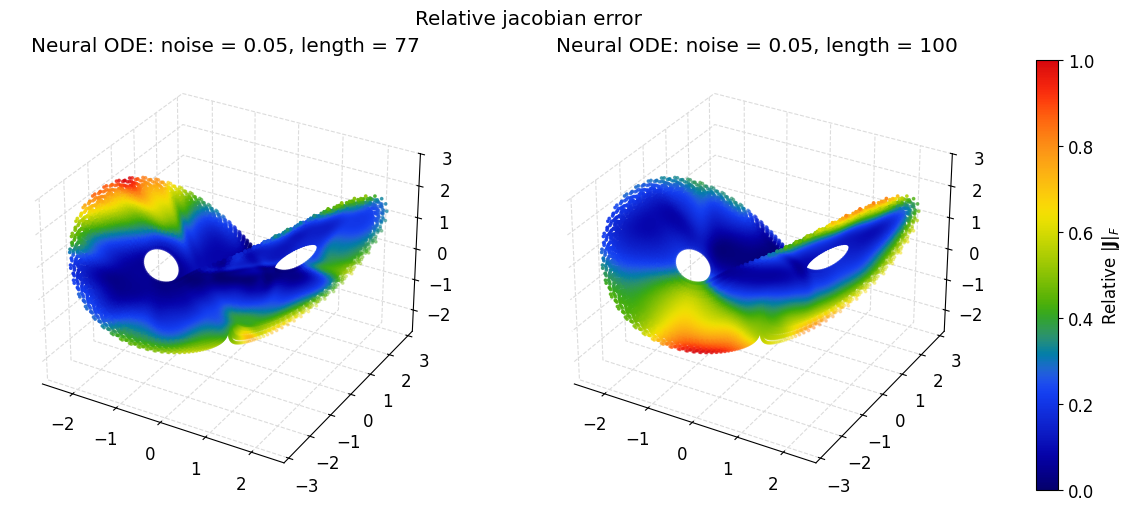

In [ ]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(12, 5),
    subplot_kw={"projection": "3d"},
)
axes[0].scatter(*u_train.T, c=jacerr1, s=3, cmap=cc.cm.rainbow4)
axes[1].scatter(*u_train.T, c=jacerr2, s=3, cmap=cc.cm.rainbow4)

axes[0].set_title("Neural ODE: noise = 0.05, length = 77")
axes[1].set_title("Neural ODE: noise = 0.05, length = 100")
fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=cc.cm.rainbow4),
    norm=matplotlib.colors.NoNorm(),
    ax=axes.ravel().tolist(),
    label=r"Relative $|\mathbf{J}|_F$",
)
fig.suptitle("Relative jacobian error")

In [107]:
model1 = load_model("results/lorenz63/latent_lstm/len=77_noise=0.0_key=0.eqx")
model2 = load_model("results/lorenz63/latent_lstm/len=100_noise=0.0_key=0.eqx")


In [108]:
def model_jacobian_discrete(model, ts, us):
    dt = ts[1] - ts[0]

    @eqx.filter_jacfwd
    def _jacobian(t_u):
        t, u = t_u
        return model.step(t, t + dt, u, None)

    @eqx.filter_vmap
    def jacobian(t, u):
        return (_jacobian((t, u))[1] - jnp.identity(model.dim)) / dt

    return jacobian(ts, us)


In [109]:
def calculate_relative_jacerr2(model, ts, us, jac_true):
    jac_model = model_jacobian_discrete(model, ts, us)
    jacerr = jnp.linalg.norm((jac_true - jac_model) ** 2, axis=(-2, -1))
    return jacerr / jnp.linalg.norm(jac_true, axis=(-2, -1))

In [110]:
jacerr1 = calculate_relative_jacerr2(model1, t_train, u_train, jac_true)
jacerr2 = calculate_relative_jacerr2(model2, t_train, u_train, jac_true)

Text(0.5, 0.98, 'Relative jacobian error')

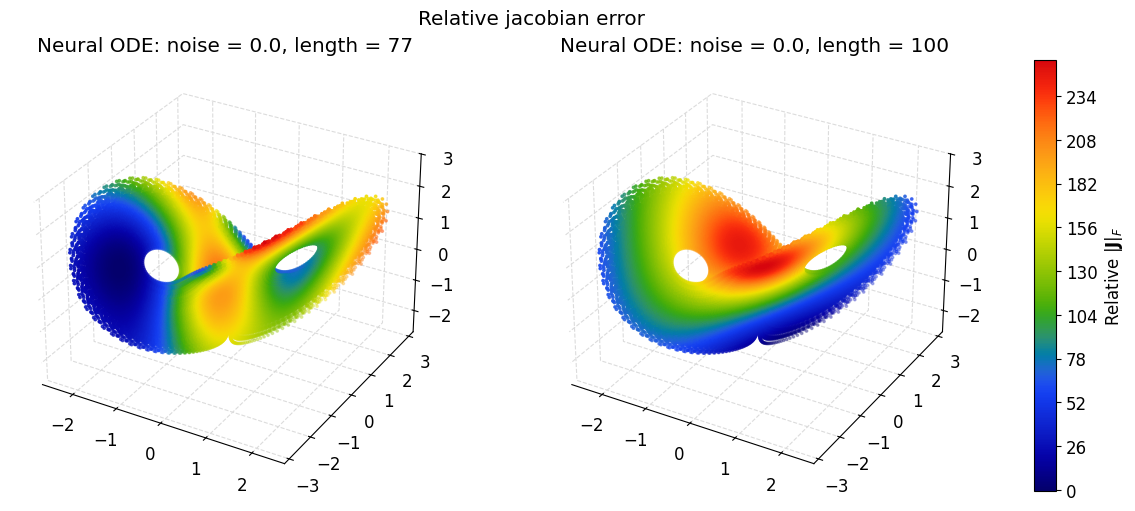

In [111]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(12, 5),
    subplot_kw={"projection": "3d"},
)
axes[0].scatter(*u_train.T, c=jacerr1, s=3, cmap=cc.cm.rainbow4)
axes[1].scatter(*u_train.T, c=jacerr2, s=3, cmap=cc.cm.rainbow4)

axes[0].set_title("Neural ODE: noise = 0.0, length = 77")
axes[1].set_title("Neural ODE: noise = 0.0, length = 100")
fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=cc.cm.rainbow4, norm=matplotlib.colors.NoNorm()),
    ax=axes.ravel().tolist(),
    label=r"Relative $|\mathbf{J}|_F$",
)
fig.suptitle("Relative jacobian error")

In [81]:
jnp.max(jacerr1)

Array(62.32468234, dtype=float64)